# 03: LightGBM hyperparam optimization

Connected to the MySQL database


c:\Users\Miguel\Desktop\Catolica Data Analytics\CPBS-TS-2\utils\database.py:44: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  daily_data = pd.read_sql(sql_query, connection)


Connection closed


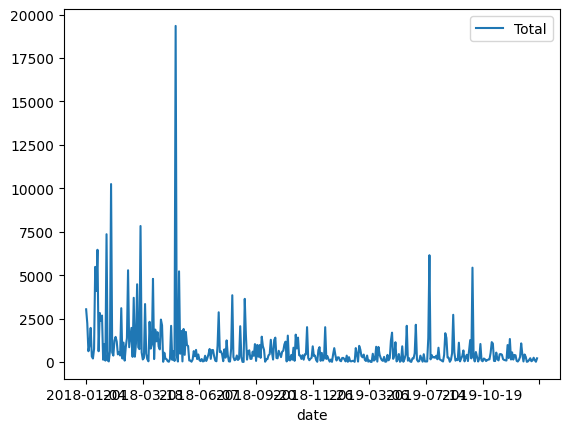

In [8]:
from utils.database import * 
from utils.utils import *
from utils.preprocessing import *
from utils.plotting import *
from utils.metrics import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import optuna
from optuna.samplers import TPESampler

# make training set 
train_index = 550
STEPS = 28

agg_levels = {
    'level_1': None,
}

daily_data = fetch_target()
daily_data = pivot_data(daily_data, "ettdeb")
train_agg = aggregation(daily_data, 
                        agg_levels=agg_levels).T
train_agg.plot(kind = "line")
train_agg = train_agg["Total"]

## Build test set

In [9]:
### CREATE X,Y ####
def create_xy(series, window_size, prediction_horizon, shuffle = False):
    x = []
    y = []
    for i in range(0, len(series)):
        if len(series[(i + window_size):(i + window_size + prediction_horizon)]) < prediction_horizon:
            break
        x.append(series[i:(i + window_size)])
        y.append(series[(i + window_size):(i + window_size + prediction_horizon)])
    x = np.array(x)
    y = np.array(y)
    return x,y

### HYPERPARAMETERS ###
window_size = 180
prediction_horizon = 1

### TRAIN VAL SPLIT ### (include shuffling later)
test_size = 28
split_time = len(train_agg) - test_size

train_series = train_agg[:split_time]
test_series = train_agg[split_time - window_size:]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

## TPE Sampler

TPE is particularly effective in high-dimensional search spaces and tends to converge to good solutions quickly. It efficiently balances exploration and exploitation by focusing the search on promising regions of the hyperparameter space while also exploring other regions to ensure thorough exploration.

Non greedy pursuit algorithm which selects the candidate with highest expected improvement as the next set of hyperparams.

Supports pruning and categorical variables. **(Complexity $Od^3$)**

In [12]:
%%time
def objective(trial):
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
    max_depth = trial.suggest_int('max_depth', 1, 10)
    num_leaves = 2 ** max_depth
    
    params = {
        'n_estimators': 1000,
        'learning_rate': 0.01,
        'max_depth': max_depth,
        'num_leaves': num_leaves,
        'boosting_type': boosting_type,
    }

    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    
    return np.mean(scores)

study = optuna.create_study(direction='maximize', sampler = TPESampler())
study.optimize(objective, n_trials=10)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-17 22:41:23,623] A new study created in memory with name: no-name-d417b379-6958-483c-a5a7-a659f4863cd8
[I 2024-03-17 22:41:51,301] Trial 0 finished with value: -398.3047325132685 and parameters: {'boosting_type': 'dart', 'max_depth': 8}. Best is trial 0 with value: -398.3047325132685.
[I 2024-03-17 22:42:09,898] Trial 1 finished with value: -458.6925693335741 and parameters: {'boosting_type': 'gbdt', 'max_depth': 7}. Best is trial 0 with value: -398.3047325132685.
[I 2024-03-17 22:42:27,672] Trial 2 finished with value: -458.7494176415478 and parameters: {'boosting_type': 'gbdt', 'max_depth': 6}. Best is trial 0 with value: -398.3047325132685.
[I 2024-03-17 22:42:33,903] Trial 3 finished with value: -427.9445487163431 and parameters: {'boosting_type': 'goss', 'max_depth': 3}. Best is trial 0 with value: -398.3047325132685.
[I 2024-03-17 22:42:54,215] Trial 4 finished with value: -458.7494176415478 and parameters: {'boosting_type': 'gbdt', 'max_depth': 6}. Best is trial 0 wit

Number of finished trials:  10
Best trial:
  Value:  -398.3047325132685
  Params: 
    boosting_type: dart
    max_depth: 8
CPU times: total: 797 ms
Wall time: 2min 52s


## Trial pruning

In [13]:
%%time
def objective(trial):
    #boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
    max_depth = trial.suggest_int('max_depth', 1, 10)
    num_leaves = 2 ** max_depth
    
    params = {
        'n_estimators': 1000,
        'learning_rate': 0.01,
        'max_depth': max_depth,
        'num_leaves': num_leaves,
        'boosting_type': 'goss',
    }

    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # Handle pruning based on the intermediate value.
    if trial.should_prune():
        # trial prunning 
        raise optuna.TrialPruned()

    return np.mean(scores)

study = optuna.create_study(direction='maximize', sampler = TPESampler())
study.optimize(objective, n_trials=10)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-17 22:44:16,260] A new study created in memory with name: no-name-7eb92b35-e1d7-41e8-90d9-52fc0fa5147f
[I 2024-03-17 22:44:22,540] Trial 0 finished with value: -427.65250993952793 and parameters: {'boosting_type': 'goss', 'max_depth': 2}. Best is trial 0 with value: -427.65250993952793.
[I 2024-03-17 22:44:40,757] Trial 1 finished with value: -396.3675586026542 and parameters: {'boosting_type': 'dart', 'max_depth': 2}. Best is trial 1 with value: -396.3675586026542.
[I 2024-03-17 22:45:04,019] Trial 2 finished with value: -458.6925693335741 and parameters: {'boosting_type': 'gbdt', 'max_depth': 9}. Best is trial 1 with value: -396.3675586026542.
[I 2024-03-17 22:45:24,753] Trial 3 finished with value: -458.7494176415478 and parameters: {'boosting_type': 'gbdt', 'max_depth': 6}. Best is trial 1 with value: -396.3675586026542.
[I 2024-03-17 22:45:34,199] Trial 4 finished with value: -427.7743193159043 and parameters: {'boosting_type': 'goss', 'max_depth': 9}. Best is trial 1 w

Number of finished trials:  10
Best trial:
  Value:  -396.3675586026542
  Params: 
    boosting_type: dart
    max_depth: 2
CPU times: total: 781 ms
Wall time: 3min 3s


##